In [35]:
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns",50)
pd.set_option("display.max_rows",None)
from sklearn.impute import SimpleImputer

In [3]:
vehicle_data = pd.read_parquet("./drive/MyDrive/vehicle_data.parquet")

In [17]:
vehicle_data.head()

,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year
0,200401BS00001,26 - 35,3.0,Urban area,4.0,1588.0,NaN,NaN,NaN,NaN,ROVER,45 CLASSIC 16V,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,NaN,Front,2004
1,200401BS00002,26 - 35,NaN,Urban area,3.0,NaN,NaN,NaN,NaN,NaN,BMW,C1,NaN,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,109,NaN,Front,2004
2,200401BS00003,26 - 35,4.0,NaN,NaN,998.0,NaN,NaN,NaN,NaN,NISSAN,MICRA CELEBRATION 16V,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,109,NaN,Front,2004
3,200401BS00003,66 - 75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LONDON TAXIS INT,TXII GOLD AUTO,NaN,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,NaN,Front,2004
4,200401BS00004,26 - 35,1.0,Urban area,4.0,124.0,NaN,NaN,NaN,NaN,PIAGGIO,VESPA ET4,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle 125cc and under,NaN,Front,2004


In [16]:
def missing_values_change(val):
    if str(val)=="Unclassified" or str(val)=='None' or str(val)=="Data missing or out of range" or str(val)=="Unallocated":
      return np.nan
    else:
      return val
for col in vehicle_data.columns:
  vehicle_data[col] = vehicle_data[col].apply(lambda x:missing_values_change(x))

In [18]:
#What percentage are missing values
ncounts = pd.DataFrame([vehicle_data.isna().mean()]).T
ncounts.columns=["percentage_missing"]

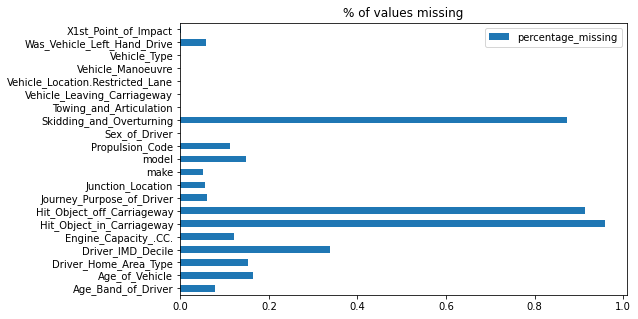

In [19]:
ncounts.query("percentage_missing>0").plot(kind="barh",figsize=(8,5),title='% of values missing')

In [20]:
ncounts


,percentage_missing
Accident_Index,0.000000
Age_Band_of_Driver,0.078565
Age_of_Vehicle,0.164499
Driver_Home_Area_Type,0.153566
Driver_IMD_Decile,0.337502
Engine_Capacity_.CC.,0.122111
Hit_Object_in_Carriageway,0.959545
Hit_Object_off_Carriageway,0.914142
Journey_Purpose_of_Driver,0.061345
Junction_Location,0.056316


In [21]:
cols_to_fill = list(ncounts.query("percentage_missing>0.01").index)  #Number of features where more than 1% of values are missing

In [22]:
cols_to_fill

['Age_Band_of_Driver',
 'Age_of_Vehicle',
 'Driver_Home_Area_Type',
 'Driver_IMD_Decile',
 'Engine_Capacity_.CC.',
 'Hit_Object_in_Carriageway',
 'Hit_Object_off_Carriageway',
 'Journey_Purpose_of_Driver',
 'Junction_Location',
 'make',
 'model',
 'Propulsion_Code',
 'Skidding_and_Overturning',
 'Was_Vehicle_Left_Hand_Drive']

In [26]:
subset = [col for col in vehicle_data.columns if col not in cols_to_fill]
vehicle_data = vehicle_data.dropna(axis=0,subset=subset)

In [29]:
vehicle_data_missing_tag_df = vehicle_data[cols_to_fill].isna()
vehicle_data_missing_tag_df.columns = [f"{c}_missing" for c in vehicle_data_missing_tag_df.columns]

In [30]:
vehicle_data = pd.concat([vehicle_data,vehicle_data_missing_tag_df],axis=1)

In [37]:
num_cols = ["Age_of_Vehicle","Engine_Capacity_.CC."]
cat_cols = [col for col in cols_to_fill if col not in num_cols]
imptr_num = SimpleImputer(strategy='mean',add_indicator=False)
imptr_cat = SimpleImputer(strategy='most_frequent',add_indicator=False)
vehicle_data_num_imputed = imptr_num.fit_transform(vehicle_data[num_cols])
vehicle_data_cat_imputed = imptr_cat.fit_transform(vehicle_data[cat_cols])


In [38]:
vehicle_data_num_imputed = pd.DataFrame(vehicle_data_num_imputed,columns=num_cols)
vehicle_data_cat_imputed = pd.DataFrame(vehicle_data_cat_imputed,columns=cat_cols)

vehicle_data_imputed = pd.concat([vehicle_data_num_imputed,vehicle_data_cat_imputed],axis=1)
vehicle_data = vehicle_data.drop(cols_to_fill,axis = 1)
vehicle_data = pd.concat([vehicle_data,vehicle_data_imputed],axis=1)

In [39]:
vehicle_data.head()

,Accident_Index,Sex_of_Driver,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,X1st_Point_of_Impact,Year,Age_Band_of_Driver_missing,Age_of_Vehicle_missing,Driver_Home_Area_Type_missing,Driver_IMD_Decile_missing,Engine_Capacity_.CC._missing,Hit_Object_in_Carriageway_missing,Hit_Object_off_Carriageway_missing,Journey_Purpose_of_Driver_missing,Junction_Location_missing,make_missing,model_missing,Propulsion_Code_missing,Skidding_and_Overturning_missing,Was_Vehicle_Left_Hand_Drive_missing,Age_of_Vehicle,Engine_Capacity_.CC.,Age_Band_of_Driver,Driver_Home_Area_Type,Driver_IMD_Decile,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Skidding_and_Overturning,Was_Vehicle_Left_Hand_Drive
0,200401BS00001,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2.0,109,Front,2004.0,False,False,False,False,False,True,True,True,True,False,False,False,True,True,3.000000,1588.000000,26 - 35,Urban area,4.0,Kerb,Other permanent object,Not known,Not at or within 20 metres of junction,ROVER,45 CLASSIC 16V,Petrol,Skidded,No
1,200401BS00002,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1.0,109,Front,2004.0,False,True,False,False,True,True,True,True,True,False,False,True,True,True,7.108259,2042.155992,26 - 35,Urban area,3.0,Kerb,Other permanent object,Not known,Not at or within 20 metres of junction,BMW,C1,Petrol,Skidded,No
2,200401BS00003,Male,No tow/articulation,Did not leave carriageway,0.0,Turning right,1.0,109,Front,2004.0,False,False,True,True,False,True,True,True,True,False,False,False,True,True,4.000000,998.000000,26 - 35,Urban area,3.0,Kerb,Other permanent object,Not known,Not at or within 20 metres of junction,NISSAN,MICRA CELEBRATION 16V,Petrol,Skidded,No
3,200401BS00003,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2.0,109,Front,2004.0,False,True,True,True,True,True,True,True,True,False,False,True,True,True,7.108259,2042.155992,66 - 75,Urban area,3.0,Kerb,Other permanent object,Not known,Not at or within 20 metres of junction,LONDON TAXIS INT,TXII GOLD AUTO,Petrol,Skidded,No
4,200401BS00004,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1.0,Motorcycle 125cc and under,Front,2004.0,False,False,False,False,False,True,True,True,True,False,False,False,True,True,1.000000,124.000000,26 - 35,Urban area,4.0,Kerb,Other permanent object,Not known,Not at or within 20 metres of junction,PIAGGIO,VESPA ET4,Petrol,Skidded,No
